# Estimate sample phases using ML
- itk user-selection
- voxel clustering
- super voxel

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import itk
import itkwidgets
from itkwidgets import view, compare

In [3]:
from glob import glob
slices = glob('../images/concrete/*.tiff')
slices.sort()
concrete = itk.imread(slices)
print(itk.size(concrete))
print(itk.spacing(concrete))

itkSize3 ([2560, 2560, 31])
itkVectorD3 ([1, 1, 1])


In [4]:
new_spacing = [1, 1, 1] #change slice thickness
concrete.SetSpacing(new_spacing)

## ITK user selection

In [5]:
myViewer = view(concrete, mode='z') #slicing over z
myViewer

Viewer(geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkImagePython.itkImageF…

In [7]:
#These are the coordinates of your crop
myViewer.roi_region()
#[789, 1102, 0], [700, 681, 31]

itkImageRegion3([846, 492, 0], [657, 545, 31])

In [8]:
myViewer.roi_slice()

(slice(0, 32, None), slice(492, 1038, None), slice(846, 1504, None))

In [49]:
# User-selection is input for slicing np array
np_concrete = itk.array_from_image(concrete) 
roi = myViewer.roi_slice()
np_coreSample = np_concrete[roi]
#view(np_coreSample, annotations=False, ui_collapsed=True)

In [50]:
np_coreSample.shape

(31, 546, 658)

In [51]:
coreSample = itk.GetImageFromArray(np.ascontiguousarray(np_coreSample))
coreSample = itk.median_image_filter(coreSample)
view(coreSample)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF3; proxy o…

In [89]:
itk.imwrite(coreSample,'../images/roiFiltered.tiff')

## Voxel clustering
- recreating volume with the least possible intensity values

In [52]:
from skimage import img_as_ubyte
np_coreSample = itk.array_from_image(coreSample)
np_coreSample = np_coreSample[:,::2,::2] #downsample for quick testing
np_coreSample = (np_coreSample - np.min(np_coreSample)) / np.max(np_coreSample-np.min(np_coreSample))
np_coreSample = img_as_ubyte(np_coreSample)

In [53]:
#plt.imshow((np_coreSample[1,:,:]))
view(np_coreSample)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

In [58]:
x, y, z = np_coreSample.shape
np_coreSampFlat = np_coreSample.reshape((-1,1))
np_coreSampFlat.shape

(2784327, 1)

In [55]:
len(np.unique(np_coreSampFlat))

202

In [56]:
from sklearn import cluster
import time
start_time = time.time()

numberOfClusters = 3
kmeans_cluster = cluster.KMeans(n_clusters=numberOfClusters)
kmeans_cluster.fit(np_coreSampFlat)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

duration = time.time() - start_time
print(f"Duration {duration} seconds")

Duration 10.845766305923462 seconds


In [90]:
img_labels = cluster_centers[cluster_labels].reshape(x, y, z)

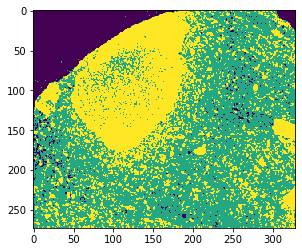

In [91]:
plt.imshow(img_labels[15,:,:]) #cmp with np_coreSample

In [95]:
itk.imwrite(itk.GetImageFromArray(img_labels),'../images/roiLabels.tiff')

TemplateTypeError: itk.ImageFileWriter is not wrapped for input type `itk.Image[itk.D,3]`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.ImageFileWriter.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.ImageFileWriter[itk.Image[itk.UC,2]].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.Image[itk.UC,2]
itk.Image[itk.UC,3]
itk.Image[itk.RGBPixel[itk.UC],2]
itk.Image[itk.RGBPixel[itk.UC],3]
itk.Image[itk.RGBAPixel[itk.UC],2]
itk.Image[itk.RGBAPixel[itk.UC],3]
itk.Image[itk.Vector[itk.F,2],2]
itk.Image[itk.Vector[itk.F,2],3]
itk.Image[itk.Vector[itk.F,3],2]
itk.Image[itk.Vector[itk.F,3],3]
itk.Image[itk.Vector[itk.F,4],2]
itk.Image[itk.Vector[itk.F,4],3]
itk.Image[itk.CovariantVector[itk.F,2],2]
itk.Image[itk.CovariantVector[itk.F,2],3]
itk.Image[itk.CovariantVector[itk.F,3],2]
itk.Image[itk.CovariantVector[itk.F,3],3]
itk.Image[itk.CovariantVector[itk.F,4],2]
itk.Image[itk.CovariantVector[itk.F,4],3]
itk.Image[itk.SS,2]
itk.Image[itk.SS,3]
itk.Image[itk.US,2]
itk.Image[itk.US,3]
itk.Image[itk.F,2]
itk.Image[itk.F,3]
itk.Image[itk.complex[itk.F],2]
itk.Image[itk.complex[itk.F],3]
itk.VectorImage[itk.SS,2]
itk.VectorImage[itk.UC,2]
itk.VectorImage[itk.US,2]
itk.VectorImage[itk.F,2]
itk.VectorImage[itk.SS,3]
itk.VectorImage[itk.UC,3]
itk.VectorImage[itk.US,3]
itk.VectorImage[itk.F,3]


In [87]:
#TODO: using img_as_ubyte here is a hack... 
img_labels = img_as_ubyte( (img_labels-np.min(img_labels))/np.max(img_labels-np.min(img_labels)) )
view(itk.GetImageFromArray(img_labels))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

In [85]:
view(img_labels,annotations=False, ui_collapsed=True,mode='z')

Viewer(annotations=False, geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIm…

## SuperPixel

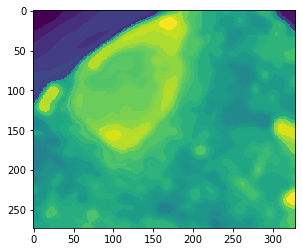

In [102]:
from skimage import color
from skimage.segmentation import slic
aSlice = np_coreSample[15,:,:]
w,h = aSlice.shape
nSegms = w*h//900 #The (approximate) number of labels in the segmented output image.
segments = slic(aSlice.astype(np.double), n_segments=nSegms, compactness=0.1, enforce_connectivity=False, sigma=5, max_iter=200, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, aSlice, kind='avg')
plt.imshow(output)

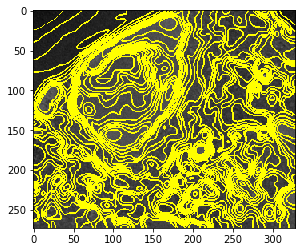

In [105]:
from skimage.segmentation import mark_boundaries
plt.imshow(mark_boundaries(aSlice, segments))

In [98]:


islic = itk.slic_image_filter(coreSample)
viewer = view(image=islic, interpolation=False, ui_collapsed=True)



TemplateTypeError: itk.ExtractImageFilter is not wrapped for input type `None`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.ExtractImageFilter.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.ExtractImageFilter[itk.Image[itk.RGBPixel[itk.UC],2], itk.Image[itk.RGBPixel[itk.UC],2]].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.Image[itk.RGBPixel[itk.UC],2]
itk.Image[itk.RGBPixel[itk.UC],3]
itk.Image[itk.RGBAPixel[itk.UC],2]
itk.Image[itk.RGBAPixel[itk.UC],3]
itk.Image[itk.Vector[itk.F,2],2]
itk.Image[itk.Vector[itk.F,2],3]
itk.Image[itk.Vector[itk.F,3],2]
itk.Image[itk.Vector[itk.F,3],3]
itk.Image[itk.Vector[itk.F,4],2]
itk.Image[itk.Vector[itk.F,4],3]
itk.Image[itk.CovariantVector[itk.F,2],2]
itk.Image[itk.CovariantVector[itk.F,2],3]
itk.Image[itk.CovariantVector[itk.F,3],2]
itk.Image[itk.CovariantVector[itk.F,3],3]
itk.Image[itk.CovariantVector[itk.F,4],2]
itk.Image[itk.CovariantVector[itk.F,4],3]
itk.Image[itk.SS,2]
itk.Image[itk.SS,3]
itk.Image[itk.UC,2]
itk.Image[itk.UC,3]
itk.Image[itk.US,2]
itk.Image[itk.US,3]
itk.Image[itk.F,2]
itk.Image[itk.F,3]
itk.Image[itk.complex[itk.F],2]
itk.Image[itk.complex[itk.F],3]
itk.Image[itk.SS,3]
itk.Image[itk.UC,3]
itk.Image[itk.US,3]
itk.Image[itk.F,3]
itk.Image[itk.RGBPixel[itk.UC],3]
itk.Image[itk.complex[itk.F],3]
